# Introduction

Google has spent over 1.1 Billion dollars on self driving cars. Uber has 1.5 Billion dollars allocated to self driving cars. Tesla has already built a sort of car autopilot into their vehicles. Self driving cars are on there way, but how do you build one?

There are two components to a self driving vehicle: the hardware (which we will ignore) and the software. Part of that software is noting other bodies moving through space, and part of that software is knowing and following the rules of the road.

My final capstone looks at how to quickly read road signs so as to be able to make snap driving decisions in high intesnsity situations. I am primarily focused on a type of machine learning model known as Convolutional Neural Networks. This project focuses on altering kernels and density layer neurons to increase accuracy while not sacrificing computational time.

The metrics I will be watching most closely are test loss and test accuracy. The lower the test loss, the more accurate our model. The closer to one our test accuracy is , the more accurate the model is. 

In [1]:
import numpy as np
import pandas as pd 
import pickle
from numba import jit, cuda
from math import sqrt, ceil
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import keras.metrics
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K
from keras.utils import plot_model
import time
import os

C:\Users\mattb\AppData\Local\Continuum\anaconda3\envs\tensorenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:

for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [6]:

with open('data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

y_train = to_categorical(data['y_train'], num_classes=43)
y_validation = to_categorical(data['y_validation'], num_classes=43)
y_test = data['y_test']

x_train = data['x_train'].transpose(0, 2, 3, 1)
x_validation = data['x_validation'].transpose(0, 2, 3, 1)
x_test = data['x_test'].transpose(0, 2, 3, 1)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43

# Modeling Experimentation

For this project, I focused on experimenting with layers to optimize my model. I started with a functional model and then began working with a sequential model. I used different layers like density layers, activation layers, addition layers, normalization layers, flatten layers and maxpool layers. I used the time it took to fit a model to measure the complexity of the model. In experimenting with my models, the longer the model took to fit, the longer it took to classify an image. I used test loss and test accuracy as my two main metrics for measuring success. 

# My Base Model

This layer formation is the minimum number of layers in order to successfully create a model. I built off of these layers for the rest of the project. I started with kernel size 10 and filters set at 32. I will go on to experiment with kernels later. With 456 seconds as my base line fit time and 1.85 test loss and .77 test accuracy, I will go on to compare other models to this one.

In [46]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = Conv2D(32, kernel_size=10, padding='same', activation='relu',
                input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dense(43, activation='softmax')(output_2)


model = Model(input_tensor, output_3)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [47]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 456.1027526855469 seconds ---


In [48]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.85465846905092
Test accuracy: 0.7705215418690187


Below is a visualization of my model. The layers are all activated in sequence.

In [49]:
plot_model(model, to_file='model1.png')

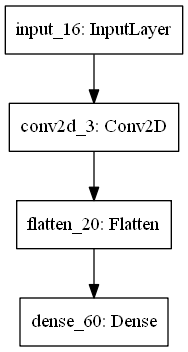

In [91]:
Image("model1.png")

# Model 2: Playing with Filters

Here I increased the filters to 64. The time to fit increased significantly, but the test loss dropped and the accuracy increased, which are both good signs.

In [50]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = Conv2D(64, kernel_size=10, padding='same', activation='relu',
                input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dense(43, activation='softmax')(output_2)


model = Model(input_tensor, output_3)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [51]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 765.9646155834198 seconds ---


In [52]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3848196682746179
Test accuracy: 0.7952380951840321


In [53]:
plot_model(model, to_file='model2.png')

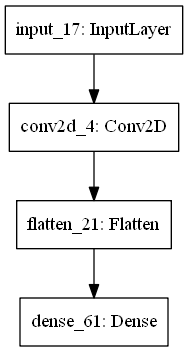

In [92]:
Image("model2.png")

# Model 3: adding a new Density Layer

Here I added an additional density layer to see if this would help increase accuracy. In this case, the density model ended up hurting the accuracy of the model.

In [54]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = Conv2D(64, kernel_size=10, padding='same', activation='relu',
                input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dense(43, activation='softmax')(output_2)
output_4 = Dense(43, activation='softmax')(output_3)


model = Model(input_tensor, output_4)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [55]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 769.6547763347626 seconds ---


In [56]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.529395399828887
Test accuracy: 0.027210884353741496


In [57]:
plot_model(model, to_file='model3.png')

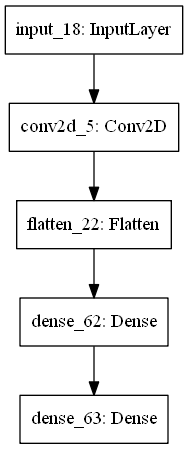

In [93]:
Image("model3.png")

# Model 4: Dropout Layer

THe dropout layer will randomly prevent or block the passing of values from one neuron. This helps with a model overfitting. I thought overfitting might be an issue since the model doesn't seem to be able to get over .77 accuracy. The dropout layer did help with the accuracy only marginally and increased the fit time pretty significantly

In [58]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = Conv2D(64, kernel_size=10, padding='same', activation='relu',
                input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dropout(20)(output_2)
output_4 = Dense(43, activation='softmax')(output_3)


model = Model(input_tensor, output_4)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [60]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 773.4076302051544 seconds ---


In [61]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9129845045050797
Test accuracy: 0.7891156461503771


In [62]:
plot_model(model, to_file='model4.png')

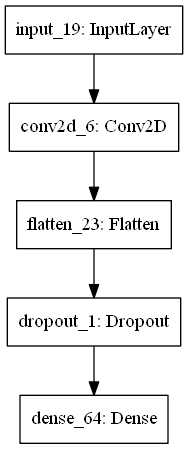

In [94]:
Image("model4.png")

# Model 5: Increased Dropout

I increased the dropout amount this time to 100 to see if the dropout layer was adding anything at all. Since the accuracy remained around .77 it seems like in this context, the dropout layer doesn't seem to be helping or hurting.

In [63]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = Conv2D(64, kernel_size=10, padding='same', activation='relu',
                input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dropout(100)(output_2)
output_4 = Dense(43, activation='softmax')(output_3)


model = Model(input_tensor, output_4)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [64]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 771.0773446559906 seconds ---


In [65]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7512020178122314
Test accuracy: 0.7691609976513315


In [66]:
plot_model(model, to_file='model5.png')

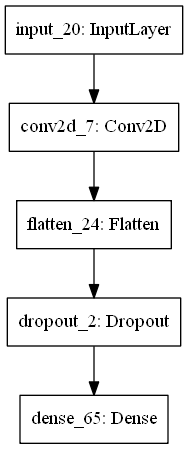

In [95]:
Image("model5.png")

# Model 6: Leaky ReLU and Locally Connected2D

ReLU is a type of activation in neural networks that helps make linear, or neuron to following neuron, paths nonlinear. Leaky ReLU is a version of ReLU. I also changed the Convolutional 2D layer to a locally Connected 2D layer. The LocallyConnected@D layer works similarly to the Conv2D layer, except that weights are unshared, that is, a different set of filters is applied at each different patch of the input. While the fit time is almost double the fit time of our original model, the accuracy has finally pushed past the .70s.

In [71]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(43, activation='softmax')(output_3)

model = Model(input_tensor, output_4)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [72]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 975.3689148426056 seconds ---


In [73]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6860482023416463
Test accuracy: 0.8122448980132468


In [74]:
plot_model(model, to_file='model7.png')

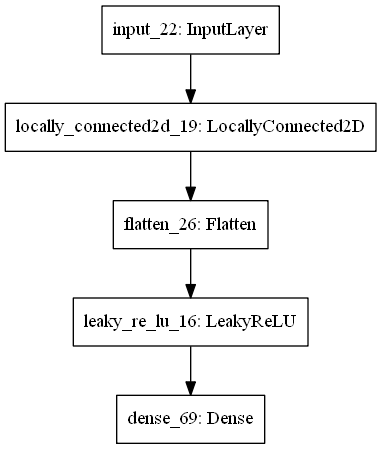

In [97]:
Image("model7.png")

# Model 7: Adding Density Layers to Leaky ReLU

Here I am experimenting with adding density layers to help the new activation. Again we can see an increase in the accuracy, at the cost of a significant fit time. 

In [67]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(100, activation='relu')(output_3)
output_5 = Dense(43, activation='relu')(output_4)
output_6 = keras.layers.LeakyReLU(alpha = 0.3)(output_5)
output_7 = Dense(43, activation='softmax')(output_6)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [68]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1612.6701128482819 seconds ---


In [69]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6303074151615436
Test accuracy: 0.8458049887161947


In [70]:
plot_model(model, to_file='model6.png')

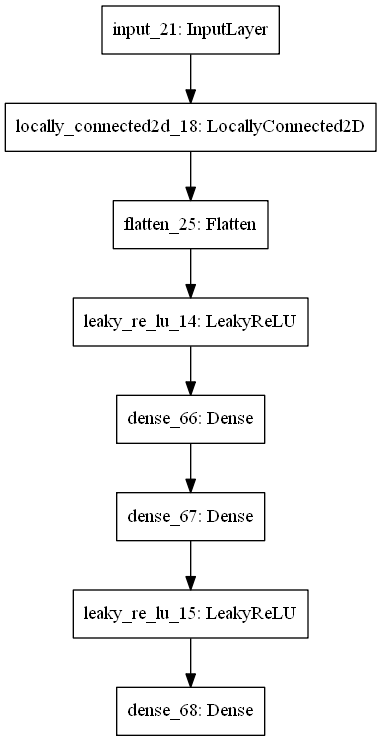

In [96]:
Image("model6.png")

# Model 8: Adding Layers Together

I am getting a baseline for the accuracy of adding layers together here. I know that low neuron density layers are ineffective at increasing accuracy, but they are quick to fit, which helps my experimentation. The test accuracy on this model is low, which is to be expected.

In [1]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = Dense(10, activation='relu')(output_2)
output_4 = Dense(10, activation='relu')(output_3)
output_5 = Dense(10, activation='relu')(output_4)

added = keras.layers.Add()([output_4, output_5])
output_6 = Dense(43, activation='softmax')(added)

model = Model(input_tensor, output_6)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

NameError: name 'Input' is not defined

In [76]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 599.8771433830261 seconds ---


In [77]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7824215904114737
Test accuracy: 0.44331065765043504


My model begins to add some intricacies at this stage.

In [78]:
plot_model(model, to_file='model8.png')

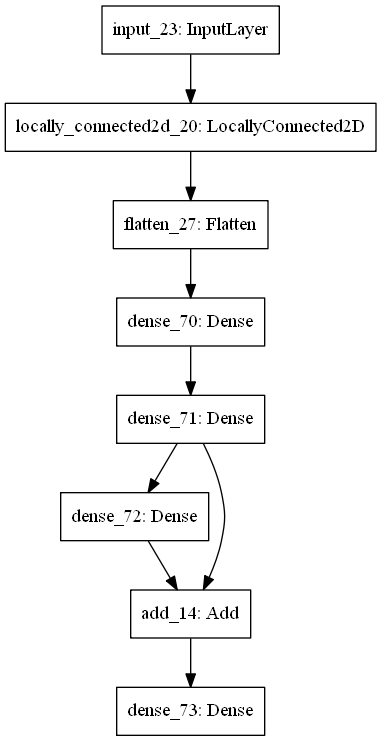

In [98]:
Image("model8.png")

# Model 9: Adding Leaky ReLU 

I added Leaky ReLU back into this model to see how the addition affected the accuracy and test loss. As you can see, both increased dramatically. 

In [79]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(10, activation='relu')(output_3)
output_5 = Dense(10, activation='relu')(output_4)
output_6 = Dense(10, activation='relu')(output_5)

added = keras.layers.Add()([output_4, output_5])
output_7 = Dense(43, activation='softmax')(added)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [80]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 651.9830675125122 seconds ---


In [81]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3881832768316982
Test accuracy: 0.562585034175795


In [82]:
plot_model(model, to_file='model10.png')

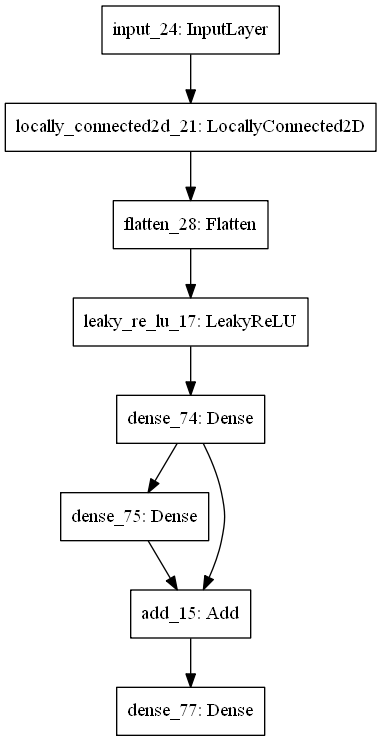

In [99]:
Image("model10.png")

# Adding Non-concurrent layers

I added layers that did not follow one another and added another density layer. The accuracy suffered tremendously.

In [83]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(10, activation='relu')(output_3)
output_5 = Dense(10, activation='relu')(output_4)
output_6 = Dense(10, activation='relu')(output_5)
output_7 = Dense(10, activation='relu')(output_6)

added = keras.layers.Add()([output_4, output_7])
output_7 = Dense(43, activation='softmax')(added)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [84]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 639.2543346881866 seconds ---


In [85]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.762279611488048
Test accuracy: 0.013605442185318119


In [86]:
plot_model(model, to_file='model11.png')

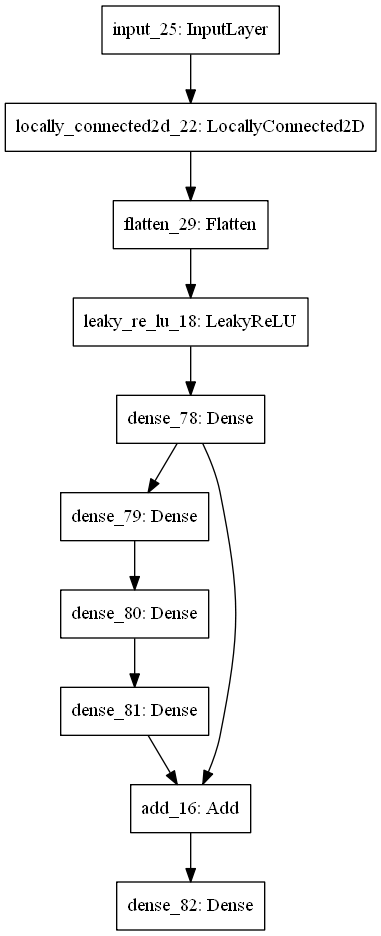

In [100]:
Image("model11.png")

# Model 12: Adding side by side models

I added the results of two sets of layers that were working in parallel. The test accuracy is higher than other addition models, but doesn't pass Model 7's success.

In [87]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(10, activation='relu')(output_3)
output_5 = Dense(10, activation='relu')(output_4)

output_tensor2 = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output2_2 = Flatten()(output_tensor2)
output2_3 = keras.layers.LeakyReLU(alpha = 0.3)(output2_2)
output2_4 = Dense(10, activation='relu')(output2_3)
output2_ = Dense(10, activation='relu')(output2_4)

added = keras.layers.Add()([output_4, output2_4])
output_7 = Dense(43, activation='softmax')(added)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])


In [88]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1155.2487454414368 seconds ---


In [89]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7712192924790372
Test accuracy: 0.799773242468196


In [90]:
plot_model(model, to_file='model12.png')

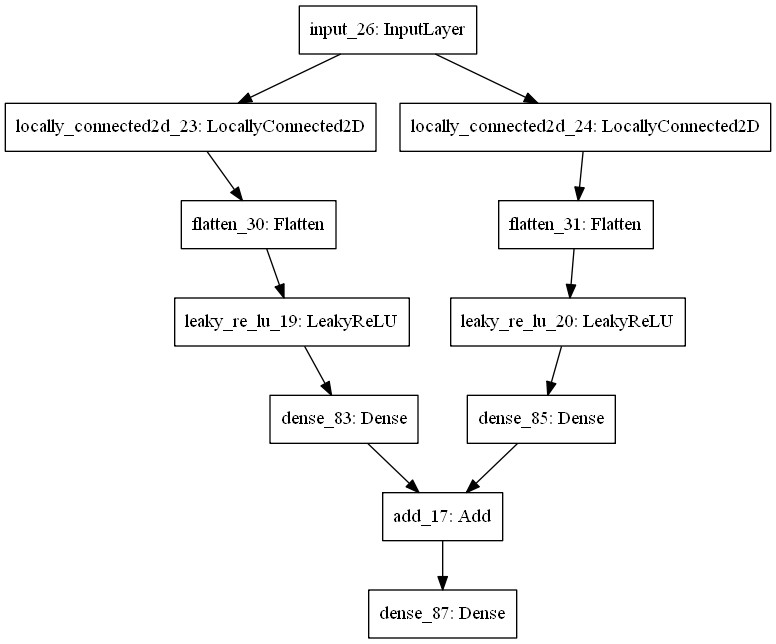

In [101]:
Image("model12.png")

# Model 13: adding leaky ReLUs together

I tried to use the Adding layer to bring together my most successful layer, with poor results: a long fit time, and average test loss and accuracy scores. 

In [102]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)

output_tensor2 = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output2_2 = Flatten()(output_tensor2)
output2_3 = keras.layers.LeakyReLU(alpha = 0.3)(output2_2)

added = keras.layers.Add()([output_3, output2_3])
output_7 = Dense(43, activation='softmax')(added)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])


In [103]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1484.9726939201355 seconds ---


In [104]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7426613238933675
Test accuracy: 0.832653061143395


# Model 14: Sequential Models

I went from Functional models to sequential models. I started working with Kernels and how kernels affect model performance. One thing I noticed right away is how quick the fitting was for these models.

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=1, padding='same', activation='relu',
                input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])


Here we are fitting the model. I timed how long each model fitting took to see if models that took longer to fit were better at performance. 

In [8]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 128.10160970687866 seconds ---


The accuracy of this model isn't terrible. This will be our baseline for model performance going forward.

In [18]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4202143292848757
Test accuracy: 0.6730158730158731


# Model 15: Kernel at 2

In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 107.99208092689514 seconds ---


In [27]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.689000676102649
Test accuracy: 0.8467120181676212


# Model 16: Kernel at 3

In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 118.07528042793274 seconds ---


In [31]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6941176410705324
Test accuracy: 0.8496598639726098


# Model 17: Kernel at 4

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 128.16905641555786 seconds ---


In [35]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9065441038062513
Test accuracy: 0.8204081631571798


# Model 18: Kernel at 5

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 145.56558513641357 seconds ---


In [39]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0918637566555656
Test accuracy: 0.8253968253157307


# Model 19: Kernal at 6

In [41]:
model = Sequential()
model.add(Conv2D(32, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 163.57180857658386 seconds ---


In [43]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8275337818798835
Test accuracy: 0.853968253833096


# Model 20: Kernel at 7

In [45]:
model = Sequential()
model.add(Conv2D(32, kernel_size=7, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 177.98179459571838 seconds ---


In [47]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9752437439635228
Test accuracy: 0.834013605307019


# Model 21: Kernel at 8

In [49]:
model = Sequential()
model.add(Conv2D(32, kernel_size=8, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 184.5063123703003 seconds ---


In [51]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9827890204193911
Test accuracy: 0.8358276644261246


# Model 22: Kernel at 9

In [53]:
model = Sequential()
model.add(Conv2D(32, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 216.8506474494934 seconds ---


In [55]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1590758565872434
Test accuracy: 0.8115646259044033


# Model 23: Kernel at 10

In [57]:
model = Sequential()
model.add(Conv2D(32, kernel_size=10, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 238.4643359184265 seconds ---


In [59]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1296773658588088
Test accuracy: 0.811791383328081


# Reflection on Kernels

It seems that for this project, performance begins to stall around 2 kernels. I will keep this as my baseline for my next model tweak: adding an additonal density layer to my model.

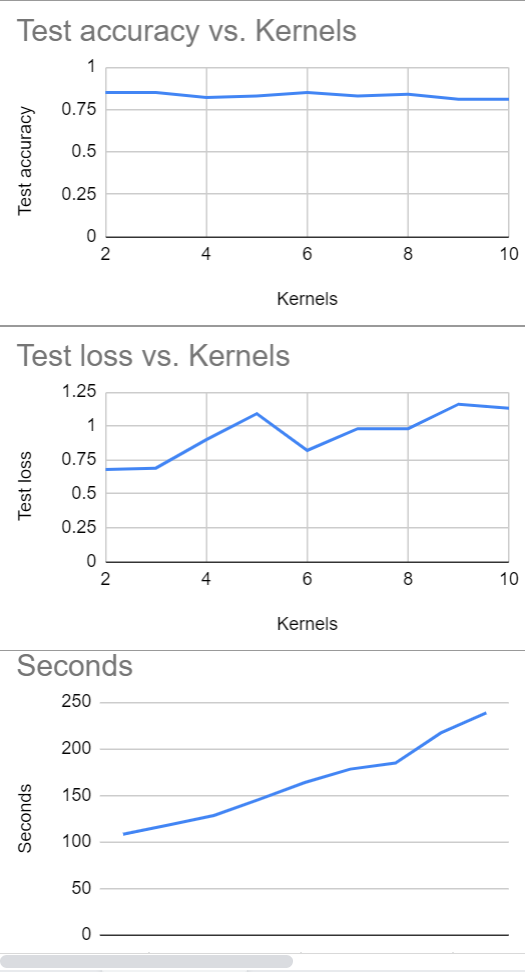

In [70]:
Image("Capture.png")

# Density Layers

Density layers feed all outputs from the previous layer through all its neurons, each neuron providing one output to the next layer. Here we are experimenting with the number of neurons in the a new density layer.  

# Model 24: Density Layer at 1

In [61]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 57.72654414176941 seconds ---


In [63]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.7562839880011247
Test accuracy: 0.013605442176870748


# Model 25: Density Layer at 10

In [64]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 64.3867347240448 seconds ---


In [66]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0613079617623569
Test accuracy: 0.668027210803259


# Model 26: Density Layer at 50

In [67]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 122.47640800476074 seconds ---


In [71]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.829659496007863
Test accuracy: 0.7768707481911934


# Model 27: Density Layer at 100 

In [73]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 218.55456018447876 seconds ---


In [75]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6007305597772403
Test accuracy: 0.8365079365619997


# Model 28: Density Layer at 150

In [77]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 305.3828456401825 seconds ---


In [79]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.777620839342779
Test accuracy: 0.8235827664939724


# Model 29: Density Layer at 200 

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 369.75259709358215 seconds ---


In [7]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8336913619992955
Test accuracy: 0.8133786848613194


# Reflections on Density Layers

It looks like in this circumstance, this new density layer either harmed or did not add anything to decreasing the test loss, and increasing the test accuracy.

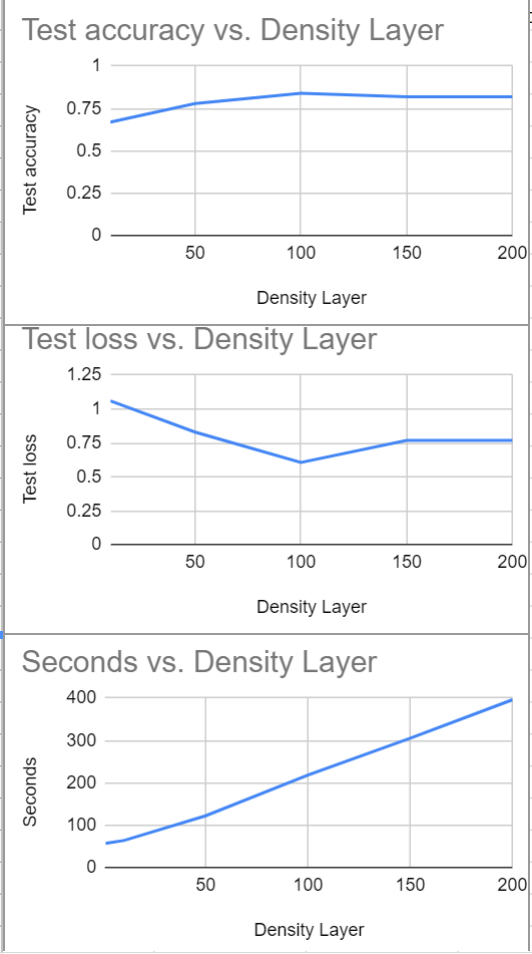

In [84]:
Image("Capture2.png")

# My Final Models: Functional vs. Sequential

My functional model performed well on accuracy and test loss, but overall took too long to classify the image. My sequential model was much faster and just as accurate

# Functional Model

In [118]:
input_tensor = Input(shape=(32, 32, 3))
output_tensor = keras.layers.LocallyConnected2D(64, (3,3), input_shape=(32, 32, 3))(input_tensor)
output_2 = Flatten()(output_tensor)
output_3 = keras.layers.LeakyReLU(alpha = 0.3)(output_2)
output_4 = Dense(100, activation='relu')(output_3)
output_5 = Dense(43, activation='relu')(output_4)
output_6 = keras.layers.LeakyReLU(alpha = 0.3)(output_5)
output_7 = Dense(43, activation='softmax')(output_6)

model = Model(input_tensor, output_7)

model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [119]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1865.5344624519348 seconds ---


In [120]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7239449163683418
Test accuracy: 0.8335600907299794


(1, 32, 32, 3)
[3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(43,)
ClassId: 3
Label: Speed limit (60km/h)
--- 7.164875030517578 seconds ---


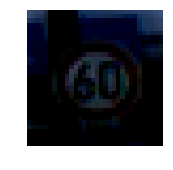

In [121]:
%matplotlib inline
start_time = time.time()

# Preparing image for predicting from test dataset
x_input = x_test[100:101]
print(x_input.shape)
y_input = y_test[100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
#plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

print("--- %s seconds ---" % (time.time() - start_time))
    

# Sequential Model

In [130]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [131]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 285.28466725349426 seconds ---


In [132]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7859328536219607
Test accuracy: 0.8233560091243579


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[3]
(43,)
ClassId: 3
Label: Speed limit (60km/h)
--- 4.82908296585083 seconds ---


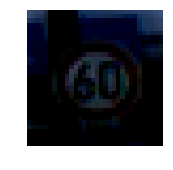

In [133]:
%matplotlib inline
start_time = time.time()

# Preparing image for predicting from test dataset
x_input = x_test[100:101]
print(x_input.shape)
y_input = y_test[100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
#plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

print("--- %s seconds ---" % (time.time() - start_time))
    

# Conclusion

My functional model performed its categorization in 7 seconds. My sequential model performed it in  5 seconds. Ultimately I would go with the sequential mode, but with the time it takes both models to classify, I wouldn;t use either in a slef-driving vehicle.